## YOLOv3구현
- YOLOv3 구조
    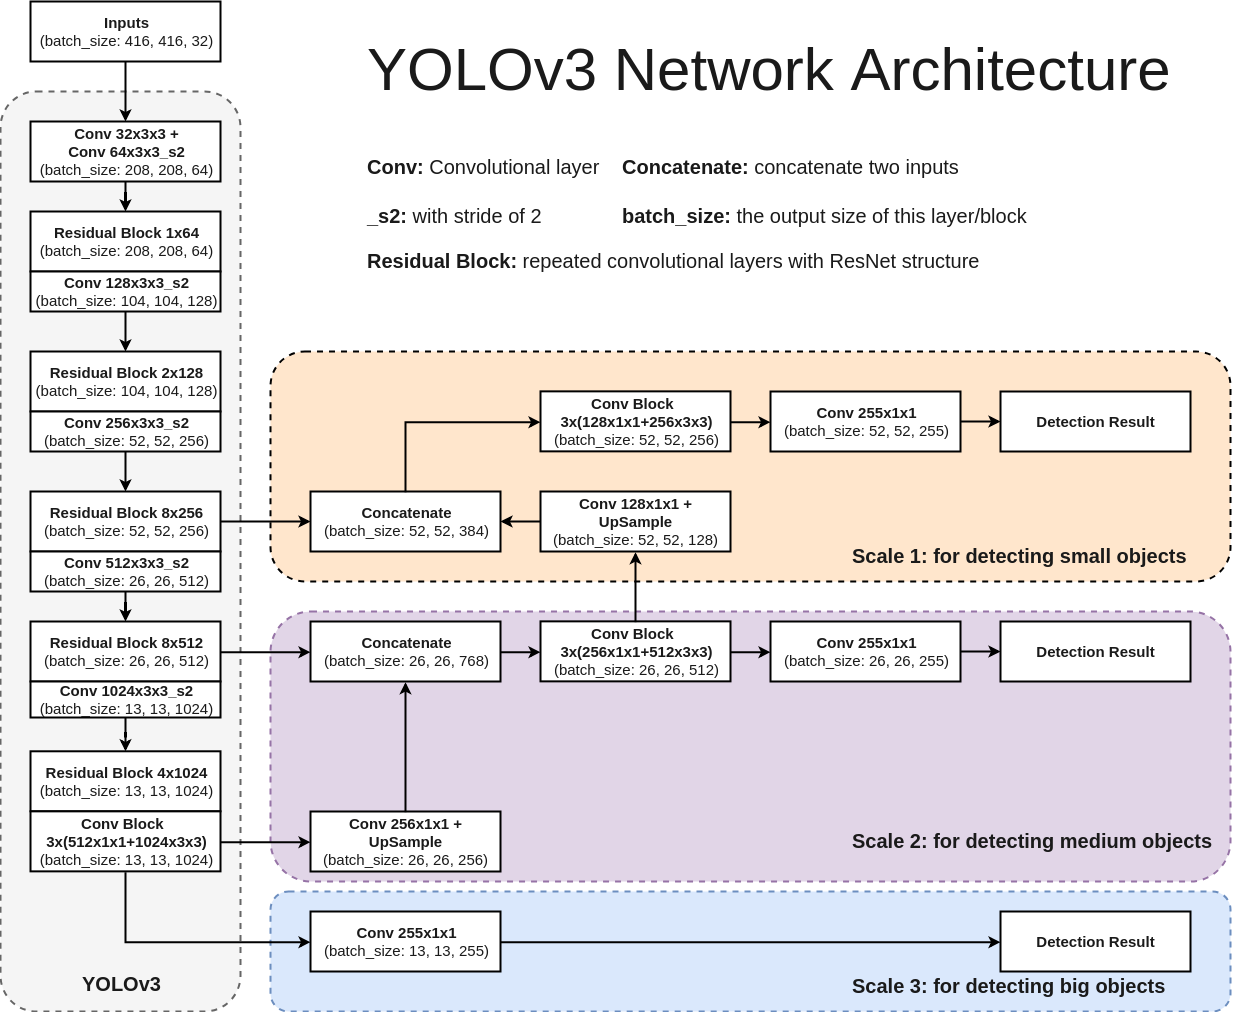

- YOLOv3 output
    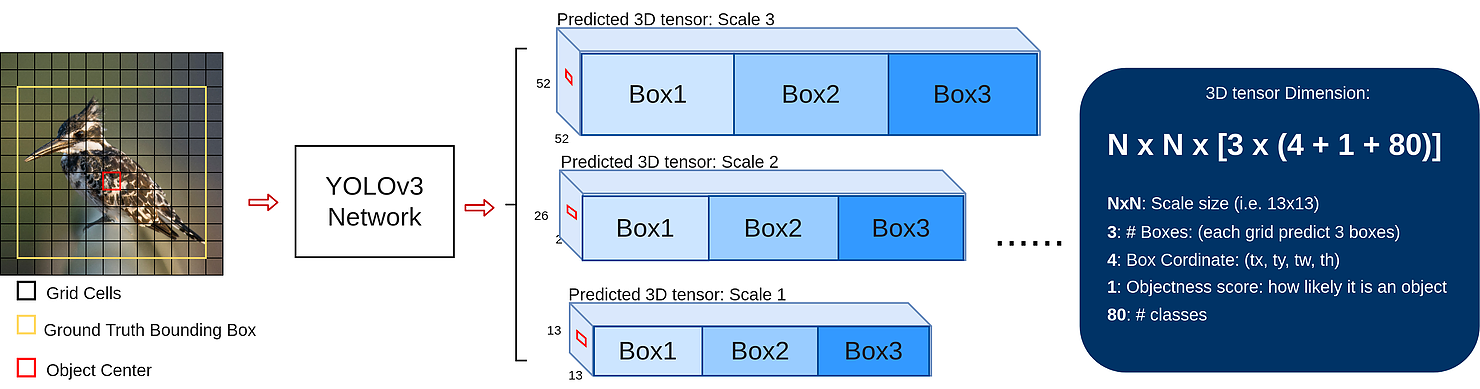

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [14]:
def Conv(in_channels, out_channels, kernel_size=3, padding=1, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU())

def make_layer(block, in_channels, num_blocks):
    layer = []
    for i in range(0, num_blocks):
        layer.append(block(in_channels))
    return nn.Sequential(*layer)
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels):
        super(ConvBlock, self).__init__()
        channel = int(in_channels/2)
        
        self.layer1 = nn.Conv2d(in_channels, channel, kernel_size=1, padding=0, stride=1, bias=False)
        self.layer2 = nn.Conv2d(channel, in_channels, kernel_size=3, padding=1, stride=1, bias=False)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out
        
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        channel = int(in_channels/2)
        
        self.layer1 = nn.Conv2d(in_channels, channel, kernel_size=1, padding=0, stride=1, bias=False)
        self.layer2 = nn.Conv2d(channel, in_channels, kernel_size=3, padding=1, stride=1, bias=False)
    
    def forward(self, x):
        residual = x
        
        out = self.layer1(x)
        out = self.layer2(out)
        out += residual
        return out

    
class DarkNet53(nn.Module):
    def __init__(self):
        super(DarkNet53, self).__init__()
        
        self.conv1 = Conv(3, 32)
        self.conv2 = Conv(32, 64, stride=2)
        self.residual_block1 = make_layer(ResidualBlock, in_channels=64, num_blocks=1)
        self.conv3 = Conv(64, 128, stride=2)
        self.residual_block2 = make_layer(ResidualBlock, in_channels=128, num_blocks=2)
        self.conv4 = Conv(128, 256, stride=2)
        self.residual_block3 = make_layer(ResidualBlock, in_channels=256, num_blocks=8)
        self.conv5 = Conv(256, 512, stride=2)
        self.residual_block4 = make_layer(ResidualBlock, in_channels=512, num_blocks=8)
        self.conv6 = Conv(512, 1024, stride=2)
        self.residual_block5 = make_layer(ResidualBlock, in_channels=1024, num_blocks=4)
        self.conv_block = make_layer(ConvBlock, in_channels=1024, num_blocks=3)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.residual_block1(out)
        out = self.conv3(out)
        out = self.residual_block2(out)
        out = self.conv4(out)
        out = self.residual_block3(out)
        residual3_feature = out
        out = self.conv5(out)
        out = self.residual_block4(out)
        residual4_feature = out
        out = self.conv6(out)
        out = self.residual_block5(out)
        out = self.conv_block(out)
        conv_feature = out
        return residual3_feature, residual4_feature, conv_feature

class YOLOv3(nn.Module):
    def __init__(self, image_size):
        super(YOLOv3, self).__init__()    
        self.darknet53 = DarkNet53()
        self.feature_map = self.darknet53(image_size)
        
        self.scale3_conv = Conv(1024, 512)
        self.scale3_conv_f = self.make_conv_final(512, 255)
        
        self.scale2_up = self.make_upsample(512, 256, scale_factor=2)
        self.scale2_conv = Conv(768, 256)
        self.scale2_conv_f = self.make_conv_final(256, 255)
        
        self.scale1_up = self.make_upsample(256, 128, scale_factor=2)
        self.scale1_conv = Conv(384, 128)
        self.scale1_conv_f = self.make_conv_final(128, 255)
    
    def forward(self):
        scale3_conv = self.scale3_conv(self.feature_map[2])
        scale3 = self.scale3_conv_f(scale3_conv)
        
        scale2_up = self.scale2_up(scale3_conv)
        scale2 = torch.cat((scale2_up, self.feature_map[1]), dim=1)
        scale2_conv = self.scale2_conv(scale2)
        scale2 = self.scale2_conv_f(scale2_conv)
        
        scale1 = self.scale1_up(scale2_conv)
        scale1 = torch.cat((scale1, self.feature_map[0]), dim=1)
        scale1_conv = self.scale1_conv(scale1)
        scale1 = self.scale1_conv_f(scale1_conv)
        
        return scale1, scale2, scale3, scale2_up, scale3_conv
        
    def make_conv_final(self, in_channels, out_channels):
        return nn.Sequential(
            Conv(in_channels, in_channels * 2, kernel_size=3),
            nn.Conv2d(in_channels * 2, out_channels, kernel_size=1, stride=1, padding=0, bias=True)
        )    
    
    def make_upsample(self, in_channels, out_channels, scale_factor):
        return nn.Sequential(
            Conv(in_channels, out_channels, kernel_size=1, padding=0),
            nn.Upsample(scale_factor=scale_factor, mode='nearest')
        )
    
    
def main():
    in_tensor = torch.rand(1, 3, 416, 416)
    print(f'In_tensor shape : {in_tensor.shape}')
    model = YOLOv3(in_tensor)
    feature = model()
    for i in range(3):
        print(f'scale{i+1} shape : {feature[i].shape}')
    print(feature[3].shape, feature[4].shape)
    
if __name__=="__main__":
    main()

In_tensor shape : torch.Size([1, 3, 416, 416])
scale1 shape : torch.Size([1, 255, 52, 52])
scale2 shape : torch.Size([1, 255, 26, 26])
scale3 shape : torch.Size([1, 255, 13, 13])
torch.Size([1, 256, 26, 26]) torch.Size([1, 512, 13, 13])
